In [ ]:
#########################################################################
##########------- Sistemas de Recomendación  ------------################
#########################################################################
# Capacitador: Julio César Bernal Fernández
# email: juliobf08@gmail.com
# Tema : Sistemas de Recomendación
# version: 1.0
#########################################################################

**Metrica que se usará para la medicion del modelo.**

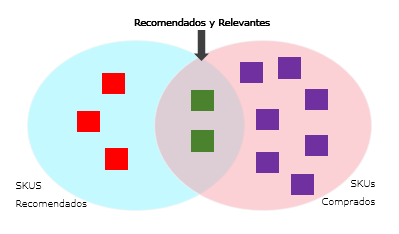


$ Recall = \frac{\lvert Recomendados \bigcap  Comprados \rvert}{\lvert Comprados \rvert} $


---
## **PARTE I - CARGAR LIBRERIA
---

In [1]:
# Cargar libreria de Sist. Recomendación
!pip install LightFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LightFM: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831162 sha256=6413bf9598a459833e4f42c1b040e3fa507de0754d856899e87cb8c26265ccb3
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built LightFM


In [2]:
# Cargamos librerias de Manejo de Datos:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos librerias de MachineLearning
from sklearn.preprocessing import MinMaxScaler
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank
from lightfm.cross_validation import random_train_test_split
import os
import csv
import time
import itertools
import scipy.sparse as sp
import pickle

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

---
## **PARTE II - ENTENDIMIENTO Y TRATAMIENTO DE DATOS **
---

In [ ]:
# zip del archivo Sistemarecomendación.zip
!unzip Sistemarecomendación.zip

In [3]:
df_train = pd.read_csv('train.csv', low_memory = False, sep = '|')

print(df_train.shape)

(2167848, 9)


In [4]:
df_train.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211
3,2022-01-31,9382,512,BO,21,V,1.0,0.153431,0.005211
4,2022-01-31,9382,525,BO,21,V,1.0,0.153431,0.005790


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167848 entries, 0 to 2167847
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fecha_compra        object 
 1   customer_id         int64  
 2   product_id          int64  
 3   type_id             object 
 4   business_id         int64  
 5   channel_id          object 
 6   cantidad_venta      float64
 7   monto_venta_transf  float64
 8   peso_venta_transf   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 148.9+ MB


In [6]:
# Convertir fecha objetct a formato DateTime
df_train['fecha_compra'] = pd.to_datetime(df_train['fecha_compra'])

In [7]:
# Revisar todas las fechas de compra
df_fechas = pd.DataFrame(df_train['fecha_compra'].sort_values(ascending = True).drop_duplicates())
df_fechas.head()

,fecha_compra
0,2022-01-31
8701,2022-02-01
15458,2022-02-02
22329,2022-02-03
28845,2022-02-04


In [8]:
df_fechas.describe()

,fecha_compra
count,327
mean,2022-08-04 05:12:39.633027584
min,2022-01-31 00:00:00
25%,2022-05-04 12:00:00
50%,2022-08-04 00:00:00
75%,2022-11-03 12:00:00
max,2023-02-04 00:00:00


In [9]:
# Ordenar las fechas
df_fechas.reset_index(inplace = True)
df_fechas.drop(['index'],axis=1, inplace= True)
df_fechas.head()

,fecha_compra
0,2022-01-31
1,2022-02-01
2,2022-02-02
3,2022-02-03
4,2022-02-04


In [10]:
df_fechas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_compra  327 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.7 KB


In [11]:
# Dar formato a la fecha en yyyymmdd (20240716)
df_fechas['fecha_string'] = df_fechas['fecha_compra'].dt.strftime('%Y%m%d')
df_fechas['fecha_string'] = df_fechas['fecha_string'].astype(int)
df_fechas.head()

,fecha_compra,fecha_string
0,2022-01-31,20220131
1,2022-02-01,20220201
2,2022-02-02,20220202
3,2022-02-03,20220203
4,2022-02-04,20220204


In [12]:
df_fechas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_compra  327 non-null    datetime64[ns]
 1   fecha_string  327 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [13]:
# Generar mi primeras condiciones para separar semanas y nro de semana
conditions = [
    df_fechas['fecha_string'] <=20220205,df_fechas['fecha_string'] <=20220212,df_fechas['fecha_string'] <=20220219,
    df_fechas['fecha_string'] <=20220226,df_fechas['fecha_string'] <=20220305,df_fechas['fecha_string'] <=20220312,
    df_fechas['fecha_string'] <=20220319,df_fechas['fecha_string'] <=20220326,df_fechas['fecha_string'] <=20220402,
    df_fechas['fecha_string'] <=20220409,df_fechas['fecha_string'] <=20220416,df_fechas['fecha_string'] <=20220423,
    df_fechas['fecha_string'] <=20220430,df_fechas['fecha_string'] <=20220507,df_fechas['fecha_string'] <=20220514,
    df_fechas['fecha_string'] <=20220521,df_fechas['fecha_string'] <=20220528,df_fechas['fecha_string'] <=20220604,
    df_fechas['fecha_string'] <=20220611,df_fechas['fecha_string'] <=20220618,df_fechas['fecha_string'] <=20220625,
    df_fechas['fecha_string'] <=20220702,df_fechas['fecha_string'] <=20220709,df_fechas['fecha_string'] <=20220716,
    df_fechas['fecha_string'] <=20220723,df_fechas['fecha_string'] <=20220731,df_fechas['fecha_string'] <=20220806,
    df_fechas['fecha_string'] <=20220813,df_fechas['fecha_string'] <=20220820,df_fechas['fecha_string'] <=20220827,
    df_fechas['fecha_string'] <=20220903,df_fechas['fecha_string'] <=20220910,df_fechas['fecha_string'] <=20220917,
    df_fechas['fecha_string'] <=20220924,df_fechas['fecha_string'] <=20221001,df_fechas['fecha_string'] <=20221008,
    df_fechas['fecha_string'] <=20221016,df_fechas['fecha_string'] <=20221022,df_fechas['fecha_string'] <=20221029,
    df_fechas['fecha_string'] <=20221105,df_fechas['fecha_string'] <=20221113,df_fechas['fecha_string'] <=20221119,
    df_fechas['fecha_string'] <=20221126,df_fechas['fecha_string'] <=20221203,df_fechas['fecha_string'] <=20221210,
    df_fechas['fecha_string'] <=20221217,df_fechas['fecha_string'] <=20221224,df_fechas['fecha_string'] <=20221231,
    df_fechas['fecha_string'] <=20230107,df_fechas['fecha_string'] <=20230114,df_fechas['fecha_string'] <=20230121,
    df_fechas['fecha_string'] <=20230128
    ]

In [ ]:
# Condiciones
values = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20',
          'S21','S22','S23','S24','S25','S26','S27','S28','S29','S30','S31','S32','S33','S34','S35','S36','S37','S38','S39',
          'S40','S41','S42','S43','S44','S45','S46','S47','S48','S49','S50','S51','S52']

In [ ]:
# Aplicar las condiciones y crear una nueva columna 'NuevaCol'
df_fechas['RangoFechas'] = np.select(conditions, values, default='Otra condición')

In [ ]:
df_fechas.head()

In [ ]:
df_fechas[df_fechas['RangoFechas'] == 'Otra condición']

In [ ]:
df_fechas['RangoFechas'].value_counts()

In [ ]:
df_fechas.head(8)

In [ ]:
df_train.shape

In [ ]:
df_train.head(2)

In [ ]:
df_train.info()

In [ ]:
# Convertir mi fecha string a una fecha en formato YYYYMMDD
df_train['fecha_string'] = df_train['fecha_compra'].dt.strftime('%Y%m%d')
df_train['fecha_string'] = df_train['fecha_string'].astype(int)
df_train.head()

In [ ]:
# Combinar las fechas con el rango de fechas
df_train_1 = pd.merge(df_train,df_fechas[['fecha_string','RangoFechas']], on = 'fecha_string',how='left')

In [ ]:
df_train_1.shape

In [ ]:
df_train_1.head()

---
## **PARTE III - ARMADO DE DATASET PARA ENTRENAR ALGORITMO **
---

In [ ]:
df_train_1.head(2)

In [ ]:
# Agrupar el DataSet a nivel rango de fechas, cliente y producto
df_agg = df_train_1.groupby(['customer_id','RangoFechas','product_id']).agg({'fecha_compra': 'nunique',
                                                                             'cantidad_venta': 'sum',
                                                                             'monto_venta_transf': 'sum',
                                                                             'peso_venta_transf' : 'sum'})
df_agg = df_agg.rename(columns={'fecha_compra': 'frecuencia',
                                'cantidad_venta': 'quantity',
                                'monto_venta_transf': 'monto',
                                'peso_venta_transf':'peso'})

In [ ]:
df_agg.head(2)

In [ ]:
# Reseteo de indices para la tabla df_agg
df_agg = df_agg.reset_index(level=['RangoFechas','customer_id','product_id'])

In [ ]:
df_agg.head(2)

---
## **PARTE IV - AGRUPAMIENTO A NIVEL CLIENTE TRAIN **
---

In [ ]:
# Agrupador a nivel Cliente y SKU par asaber con que frecuencia, monto y volumen
# me compra ese cliente el SKU
train = df_agg.pivot_table(
    index = ['customer_id', 'product_id'],#, 'name'
    aggfunc = {'frecuencia':'sum','peso':'sum','monto':'sum'}
)
train.columns = ['sum_frecuencia','sum_volumen','sum_monto']
train.reset_index(inplace = True)

In [ ]:
train.head(2)

In [ ]:
train.shape

In [ ]:
train.describe()

---
## **PARTE V - TRATAMIENTO Y TRANSFORMACIÓN DE VARIABLES **
---

In [ ]:
# Escalamiento de Variables
vars_final = ["sum_frecuencia", "sum_volumen", "sum_monto"]
vars_scaled = [s + '_scaled' for s in vars_final]

# Train
scaler = MinMaxScaler((0.5, 1.5))
train.loc[:, vars_scaled] = scaler.fit_transform(train.loc[:, vars_final])


In [ ]:
train.head(2)

In [ ]:
train.loc[:, vars_final].corr()

In [ ]:
train.loc[:, vars_scaled].corr()

---
## **PARTE VI - CALCULO DE VARIABLE RATING **
---

In [ ]:
# Creación de la variable rating
train['rating_prom'] = train['sum_volumen_scaled']

In [ ]:
train['rating_prom'].describe()

In [ ]:
# Se añade el rating como múltiplo de num_visitas como pesos para la matriz de interacciones
train['weights'] = train['rating_prom'] * train['sum_frecuencia']

In [ ]:
train['weights'].describe()

In [ ]:
# DataSetFinal
# df_ratings = pd.concat([train, test])
df_ratings = train.copy()

#customer_id	product_id	sum_frecuencia	sum_cantidad	sum_monto	sum_volumen

In [ ]:
df_ratings.head(2)

In [ ]:
df_ratings[["customer_id", "product_id", "weights", "rating_prom"]].to_csv("DataRatings.csv", index=False)

---
## **PARTE VII - CARACTERISTICAS DE CLIENTES Y PRODUCTOS **
---

In [ ]:
# Lectura de caracteristicas de productos
df_products = pd.read_csv('Product.csv', low_memory= False,sep ='|')
df_products.head()

In [ ]:
df_products[["product_id", "family_id", "category_id"]].to_csv("DataProductos.csv", index=False)

In [ ]:
# Lectura de caracteristicas de clientes
# df_union = pd.concat([df_train,df_test])
df_union = df_train.copy()
df_union.head(2)
# business_id, type_id df_train.head() df_test.head()

In [ ]:
# Agrupar a nivel cliente y filtrar unicamente un solo business_id
df_cli = df_union.groupby(['customer_id']).agg({'type_id': 'max',
                                                'business_id': 'max'})
df_cli.head(2)

In [ ]:
df_cli = df_cli.reset_index(level=['customer_id'])
df_cli.head(2)

In [ ]:
df_cli['business_id'].fillna('ND').value_counts(1)

In [ ]:
df_cli['type_id'].fillna('ND').value_counts(1)

In [ ]:
df_cli[df_cli['type_id'].fillna('ND')=='ND']['business_id'].value_counts()

In [ ]:
df_cli['type_id']=df_cli['type_id'].fillna('OT')

In [ ]:
df_cli['type_id'].value_counts()

In [ ]:
df_cli['customer_id'].nunique(),df_cli.shape

In [ ]:
df_cli.head(2)

In [ ]:
df_cli.to_csv("DataClientes.csv", index=False)

---
## **PARTE VIII - DATASET PARA MODELO LIGHTFM **
---

In [ ]:
def get_data():

    file1 = 'DataRatings.csv'
    file2 = 'DataProductos.csv'
    file3 = 'DataClientes.csv'

    if not os.path.exists(file1) or not os.path.exists(file2) or not os.path.exists(file3):
        print('Dataset not found, please download the file')

    return (
        csv.DictReader(
            open(file1, encoding="utf8"), delimiter=","
        ),
        csv.DictReader(
            open(file2, encoding="utf8"), delimiter=","
        ),
        csv.DictReader(
            open(file3, encoding="utf8"), delimiter=","
        ),
    )


def get_ratings():

    return get_data()[0]


def get_item_features():

    return get_data()[1]

def get_user_features():

    return get_data()[2]

In [ ]:
ratings, item_features, user_features = get_data()

In [ ]:
# Validar lectura
import json
from itertools import islice

for line in islice(ratings, 2):
    print(json.dumps(line, indent=4))

for line in islice(item_features, 2):
    print(json.dumps(line, indent=4))

for line in islice(user_features, 2):
    print(json.dumps(line, indent=4))

In [ ]:
# Identificación de los ID de users-items
dataset = Dataset()
dataset.fit((x['customer_id'] for x in get_ratings()),
            (x['product_id'] for x in get_ratings()))

num_users, num_items = dataset.interactions_shape()
print('Num_users: {}, num_items {}.'.format(num_users, num_items))

In [ ]:
# Se agregan características de los productos
dataset.fit_partial(items=(x['product_id'] for x in get_item_features()),
                    item_features=(x['category_id'] for x in get_item_features()))

dataset.fit_partial(items=(x['product_id'] for x in get_item_features()),
                    item_features=(x['family_id'] for x in get_item_features()))


# Se agregan características de los clientes
dataset.fit_partial(users=(x['customer_id'] for x in get_user_features()),
                    user_features=(x['type_id'] for x in get_user_features()))

dataset.fit_partial(users=(x['customer_id'] for x in get_user_features()),
                    user_features=(x['business_id'] for x in get_user_features()))


In [ ]:
# Se arma la matrix de interacciones
(interactions, weights) = dataset.build_interactions(((x['customer_id'], x['product_id'], float(x['weights']))
                                                      for x in get_ratings()))

print(repr(interactions))

In [ ]:
# Que tan densa es la matrix?
interactions.todense()

In [ ]:
weights.todense()

In [ ]:
item_features = dataset.build_item_features(((x['product_id'], [x['category_id'], x['family_id']])
                                              for x in get_item_features()))
print(repr(item_features))

user_features = dataset.build_user_features(((x['customer_id'], [x['type_id'], x['business_id']])
                                              for x in get_user_features()))
print(repr(user_features))

In [ ]:
interactions.shape

---
## **PARTE IX - ENTRENAMIENTO DEL MODELO **
---

In [ ]:
df = df_ratings.copy()

In [ ]:
df.head(2)

In [ ]:
df = df.rename(columns = {'customer_id': 'user_id', 'product_id': 'item_id'})

In [ ]:
interactions = interactions.tocoo()
weights = weights.tocoo()

shape = interactions.shape
uids, iids, data = (interactions.row, interactions.col, interactions.data)
shape_w = weights.shape
uids_w, iids_w, data_w = (weights.row, weights.col, weights.data)


train = sp.coo_matrix(
    (data, (uids, iids)),
    shape=shape,
    dtype=interactions.dtype,
)


train_weights = sp.coo_matrix(
    (data_w, (uids_w, iids_w)),
    shape=shape_w,
    dtype=weights.dtype,
)

In [ ]:
start = time.time()

hyperparams = {'random_state': 12, 'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp',
               'learning_rate': 0.01, 'item_alpha': 3.1954804269516023e-09, 'user_alpha': 1.9321342863036507e-09,
               'max_sampled': 11, 'num_epochs': 54, 'num_threads': 1}

num_epochs = hyperparams.pop("num_epochs")
num_threads = hyperparams.pop("num_threads")

model = LightFM(**hyperparams)
model.fit(train,
          user_features=user_features,
          item_features=item_features,
          sample_weight = train_weights,
          epochs=num_epochs,
          num_threads=num_threads,
          verbose=True)

end = time.time()
print("Execution time in seconds: ", end - start)

---
## **PARTE X - METRICAS FINALES **
---

AUC = La probabilidad de que un ejemplo positivo (relevante) seleccionado al azar tenga un score mayor que un ejemplo negativo.

In [ ]:
# Cantidad total de recomendaciones a generar
top_k = 30

In [ ]:
train_auc = auc_score(model, test_interactions=train, user_features=user_features, item_features=item_features).mean()
print('Mean train set AUC: %s' % train_auc)

train_precision = precision_at_k(model, test_interactions=train, user_features=user_features, item_features=item_features, k=top_k).mean()
print('Mean train set Precision: %s' % train_precision)

train_recall = recall_at_k(model, test_interactions=train, user_features=user_features, item_features=item_features, k=top_k).mean()
print('Mean train set Recall: %s' % train_recall)

train_rrank = reciprocal_rank(model, test_interactions=train, user_features=user_features, item_features=item_features).mean()
print('Mean train set Reciprocal Rank: %s' % train_rrank)

---
## **PARTE XI - OBTENER LAS RECOMENDACIONES **
---

In [ ]:
def get_recommendations(model, interactions, item_features, user_features, mapp, exclude_pos=False, top_n=10):

    dict_user_id = mapp[0]
    dict_item_id = mapp[2]

    # user_list = list(dict_user_id.keys())
    items_list = list(dict_item_id.keys())
    items = np.array(items_list)

    d_user_pred = {}

    for user in dict_user_id.keys():
        d_user_pred[user] = []

    for uid, i in dict_user_id.items():
        # known_positives_ids = items[interactions.tocsr()[i].indices]
        scores = model.predict(user_ids = i,
                               item_ids = np.arange(len(dict_item_id)),
                               item_features=item_features,
                               user_features=user_features
                              )

        # se obtienen las recomendaciones en orden de importancia
        top_items_ids = items[np.argsort(-scores)]

        if exclude_pos:
            # se excluyen los productos ya adquiridos de las recomendaciones
            known_positives_ids = items[interactions.tocsr()[i].indices]
            top_items_ids = [item_id for item_id in top_items_ids if item_id not in known_positives_ids]

        d_user_pred[uid] = top_items_ids[:top_n]


    pred_df  = pd.DataFrame.from_dict(d_user_pred, orient='index').iloc[:,:]
    pred_df['user_id'] = pred_df.index
    pred_df = pred_df.melt(id_vars='user_id')
    pred_df.columns = ['user_id','rank','item_id']
    pred_df = pred_df.groupby('user_id').aggregate(lambda tdf: tdf.tolist()).reset_index()
    pred_df = pred_df.explode(['rank','item_id'], ignore_index = True)

    return pred_df

In [ ]:
mapp = dataset.mapping()
df_pred = get_recommendations(model, train, item_features, user_features, mapp, exclude_pos=False, top_n=top_k)
df_pred = df_pred.rename(columns = {'user_id': 'customer_id', 'item_id': 'product_id'})
df_pred['product_id'] = df_pred['product_id'].astype("int64")
df_pred['customer_id'] = df_pred['customer_id'].astype("int64")

In [ ]:
df_pred.head(51)

In [ ]:
df_pred[['customer_id','product_id','rank']].to_csv('output.csv', sep='|', index = False)